# **RETO HACKATON**: *CIENCIA DE DATOS - CAIXA BANK*
*Carlos Cabruja - Data*

## Background

El IBEX 35 es el índice oficial de la bolsa española compuesto por las 35 empresas más negociadas del mercado. Este índice nos muestra en tiempo real si los precios en bolsa están subiendo o bajando, por lo que permite medir el comportamiento de este conjunto de acciones.

El IBEX35 sirve como punto de referencia para los inversores del mercado español. La rentabilidad de este índice es el objetivo a batir por los gestores.

Por lo tanto, la modelización de las dinámicas de este tipo de índices resultan esenciales para la toma de decisiones por parte de todas las entidades bursátiles.

## Reto

1. Desarrolla un modelo predictivo que permita predecir la variable target (si el precio de cierre del IBEX35 será superior o inferior al precio de cierre actual).

Para ello deberas entrenar tu modelo con los datos de training (si también se usan los tweets se sumaran 100 puntos) e introducir como input de tu modelo el dataset test_x para realizar las predicciones.

2. Crea un breve documento (máx. 2 páginas) o presentación (máx. 4 slides) explicando la solución que has empleado y porque la has empleado.

## Librerías

In [224]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import nltk
import datetime as dt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Recopilación y análisis de datos

In [225]:
# cargamos los datasets a trabajar
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test_x.csv')
tweets = pd.read_csv('data/tweets_from2015_#Ibex35.csv')

In [226]:
train # visualizamos los datos de entrenamiento

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
...,...,...,...,...,...,...,...,...
6549,2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0
6550,2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0
6551,2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0
6552,2019-05-29,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0


In [227]:
test # visualizamos los datos de prueba

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [228]:
tweets # visualizamos los datos de tweets

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,He hecho el repaso de todos los componentes de...
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,Els projectes que han presentat les empreses d...
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ..."
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."
...,...,...,...
9796,Thu Jan 08 16:41:36 +0000 2015,elEconomistaes,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1..."
9797,Sat Jan 03 17:20:30 +0000 2015,Roger_bolsa,Un vistazo a los #Bluechips del #Ibex #Ibex35....
9798,Sat Jan 10 19:42:45 +0000 2015,Secretosdebolsa,Así comienza la #Bolsa en #2015 Ojo a los sopo...
9799,Sat Jan 10 21:47:17 +0000 2015,Roger_bolsa,Análisis del #BancoSantander #Santander #SAN t...


Estan correctamente cargados csv, ahora vamos su tipo y si presentan valores nulos.

In [229]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6554 entries, 0 to 6553
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6554 non-null   object 
 1   Open       6421 non-null   float64
 2   High       6421 non-null   float64
 3   Low        6421 non-null   float64
 4   Close      6421 non-null   float64
 5   Adj Close  6421 non-null   float64
 6   Volume     6421 non-null   float64
 7   Target     6554 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 409.8+ KB


Habrá que hacer tratamiento de nulls en los datos y convertir la columna **Date** en datetime

In [230]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_index  726 non-null    int64  
 1   Date        726 non-null    object 
 2   Open        726 non-null    float64
 3   High        726 non-null    float64
 4   Low         726 non-null    float64
 5   Close       726 non-null    float64
 6   Adj Close   726 non-null    float64
 7   Volume      726 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.5+ KB


Parece ya encontrase limpia y lista para ser procesada.

In [231]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9801 entries, 0 to 9800
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetDate  9799 non-null   object
 1   handle     9798 non-null   object
 2   text       9797 non-null   object
dtypes: object(3)
memory usage: 229.8+ KB


Hacer **tweetdate** un Date para que pueda hacer merge con nuestro dataframe de train, y tratamiento de nulls

### Limpieza de datos

In [232]:
# cuantos nulls tiene tweets?
tweets.isnull().sum()

tweetDate    2
handle       3
text         4
dtype: int64

In [233]:
# filas con nulls en tweetDate
tweets[tweets.tweetDate.isnull()]

,tweetDate,handle,text
6931,NaN,NaN,NaN
9634,NaN,NaN,NaN


No hay nada, eliminamos....

In [234]:
# eliminar filas con nulls en tweetDate
tweets = tweets.dropna(subset=['tweetDate'])

# filas con nulls en text
tweets[tweets.text.isnull()]

,tweetDate,handle,text
1070,Mon Mar 08 07:13:57 +0000 2021,pharma_jonpi,NaN
9667,Y Montoro dando caña....,NaN,NaN


Tampoco son relevantes los tweets que no tienen fecha de publicación, ni texto de los tweets.

In [235]:
# eliminar todos los nulls
tweets = tweets.dropna()
tweets.isnull().sum()

tweetDate    0
handle       0
text         0
dtype: int64

In [236]:
# convertir Date a datetime YYYY-MM-DD
try:
    tweets['tweetDate'] = pd.to_datetime(tweets['tweetDate'])
except Exception as e:
    print(e)

Unknown string format: #Bolsa #IBEX35 https://t.co/2wBR9k3hHr


Como **tweetdate** está contaminada con texto la vamos a tratar fila por fila. 

In [237]:
for i in tweets['tweetDate']:
    lista_i = str(i).split(' ')
    if len(lista_i) != 6: # si no tiene 6 elementos (YYYY-MM-DD HH:MM:SS)
        # eliminar filas con fechas mal formateadas
        tweets = tweets.drop(tweets[tweets['tweetDate'] == i].index)

In [238]:
# convertir Date a datetime YYYY-MM-DD
tweets['tweetDate'] = pd.to_datetime(tweets['tweetDate'])

In [239]:
# renombrar tweetDate a Date
tweets = tweets.rename(columns={'tweetDate': 'Date'})

Y la columna handle no nos sirve ya que no daremos importancia a quién ha escrito el tweet.

In [240]:
# eliminar handle de los tweets
tweets = tweets.drop(['handle'], axis=1)
tweets

,Date,text
0,2022-04-09 14:47:45+00:00,He hecho el repaso de todos los componentes de...
1,2022-04-07 19:14:36+00:00,Els projectes que han presentat les empreses d...
2,2022-04-04 16:48:45+00:00,"Por si no lo has visto, o no lo encuentras en ..."
3,2022-04-05 07:23:16+00:00,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
4,2022-03-31 16:07:43+00:00,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."
...,...,...
9796,2015-01-08 16:41:36+00:00,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1..."
9797,2015-01-03 17:20:30+00:00,Un vistazo a los #Bluechips del #Ibex #Ibex35....
9798,2015-01-10 19:42:45+00:00,Así comienza la #Bolsa en #2015 Ojo a los sopo...
9799,2015-01-10 21:47:17+00:00,Análisis del #BancoSantander #Santander #SAN t...


Ahora creamos la columna sentimiento, con la libreria de Sentiment Analysis de NLTK.

**Análisis de sentimiento VADER:**
VADER (Valence Aware Dictionary and sEntiment Reasoner) es una herramienta de análisis de sentimientos basada en reglas y léxico que está específicamente en sintonía con los sentimientos expresados ​​en las redes sociales. VADER usa una combinación de un léxico de sentimientos es una lista de características léxicas (por ejemplo, palabras) que generalmente se etiquetan según su orientación semántica como positivas o negativas. VADER no solo informa sobre la puntuación de positividad y negatividad, sino que también nos informa sobre qué tan positivo o negativo es un sentimiento.

In [241]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer() # instanciamos el analizador

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [242]:
tweets['sentiment'] = tweets['text'].apply(lambda x: sentiment.polarity_scores(x)['compound'])
tweets

,Date,text,sentiment
0,2022-04-09 14:47:45+00:00,He hecho el repaso de todos los componentes de...,0.0000
1,2022-04-07 19:14:36+00:00,Els projectes que han presentat les empreses d...,0.0000
2,2022-04-04 16:48:45+00:00,"Por si no lo has visto, o no lo encuentras en ...",-0.5267
3,2022-04-05 07:23:16+00:00,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...,0.0000
4,2022-03-31 16:07:43+00:00,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0...",0.0000
...,...,...,...
9796,2015-01-08 16:41:36+00:00,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1...",0.0000
9797,2015-01-03 17:20:30+00:00,Un vistazo a los #Bluechips del #Ibex #Ibex35....,0.0000
9798,2015-01-10 19:42:45+00:00,Así comienza la #Bolsa en #2015 Ojo a los sopo...,0.0000
9799,2015-01-10 21:47:17+00:00,Análisis del #BancoSantander #Santander #SAN t...,0.0000


In [243]:
# eliminar text
tweets = tweets.drop(['text'], axis=1)

Ahora, a fin de hacer el merge con train, trataremos los datos para que sea solo una fecha.

Para los tweets hechos en una misma fecha pero distinta hora, se hará una media de los sentimientos.

In [244]:
# convertir Date a datetime YYYY-MM-DD
tweets['Date'] = pd.to_datetime(tweets['Date']).dt.date

In [245]:
# eliminar Dates repetidos con el mismo sentimiento y fecha
tweets = tweets.drop_duplicates()

# hay alguna fecha repetida con distinto sentimiento?
tweets.groupby(['Date', 'sentiment']).count()

Empty DataFrame
Columns: []
Index: [(2015-01-03, 0.0), (2015-01-04, 0.0), (2015-01-05, -0.5267), (2015-01-05, 0.0), (2015-01-06, -0.743), (2015-01-06, 0.0), (2015-01-07, 0.0), (2015-01-08, 0.0), (2015-01-09, 0.0), (2015-01-10, 0.0), (2015-01-11, 0.0), (2015-01-12, -0.296), (2015-01-12, 0.0), (2015-01-14, 0.0), (2015-01-15, -0.7345), (2015-01-16, 0.0), (2015-01-19, 0.0), (2015-01-20, 0.0), (2015-01-21, 0.0), (2015-01-22, 0.0), (2015-01-24, 0.0), (2015-01-25, 0.0), (2015-01-26, 0.0), (2015-01-27, 0.0), (2015-01-28, 0.0), (2015-01-29, 0.0), (2015-01-30, 0.0), (2015-01-31, 0.0), (2015-02-01, 0.0), (2015-02-02, 0.0), (2015-02-03, -0.296), (2015-02-03, 0.0), (2015-02-04, 0.0), (2015-02-05, 0.0), (2015-02-06, 0.0), (2015-02-07, 0.0), (2015-02-09, 0.0), (2015-02-10, 0.0), (2015-02-11, 0.34), (2015-02-12, 0.0), (2015-02-13, 0.0), (2015-02-14, 0.0), (2015-02-17, 0.0), (2015-02-18, -0.296), (2015-02-19, 0.0), (2015-02-20, 0.0), (2015-02-22, 0.0), (2015-02-23, 0.0), (2015-02-25, 0.0), (2015-02-27, -0.296), (2015-02-27, 0.0), (2015-03-01, 0.0), (2015-03-02, -0.296), (2015-03-02, 0.0), (2015-03-03, -0.296), (2015-03-03, 0.0), (2015-03-03, 0.34), (2015-03-04, 0.0), (2015-03-05, -0.6249), (2015-03-05, 0.0), (2015-03-06, 0.0), (2015-03-07, 0.0), (2015-03-08, -0.5574), (2015-03-08, 0.0), (2015-03-09, -0.5574), (2015-03-09, 0.0), (2015-03-09, 0.3612), (2015-03-10, 0.0), (2015-03-11, 0.0), (2015-03-12, 0.0), (2015-03-13, 0.0), (2015-03-14, 0.0), (2015-03-15, -0.296), (2015-03-15, 0.0), (2015-03-16, 0.0), (2015-03-16, 0.2942), (2015-03-18, 0.0), (2015-03-19, 0.0), (2015-03-20, 0.0), (2015-03-20, 0.4003), (2015-03-21, 0.0), (2015-03-22, 0.0), (2015-03-22, 0.0516), (2015-03-23, 0.0), (2015-03-24, 0.0), (2015-03-26, 0.0), (2015-03-26, 0.0772), (2015-03-27, -0.6249), (2015-03-27, 0.0), (2015-03-28, 0.0), (2015-03-29, 0.0), (2015-03-29, 0.2023), (2015-03-30, 0.0), (2015-03-31, 0.0), (2015-03-31, 0.5859), (2015-04-02, 0.0), (2015-04-03, 0.0), (2015-04-04, 0.0), (2015-04-05, 0.0), (2015-04-07, 0.0), ...]

[4483 rows x 0 columns]

In [246]:
# sacamos las fechas repetidas con distinto sentimiento
temp_df = tweets.groupby(['Date']).count()
lista_fechas = temp_df[temp_df['sentiment'] > 1].index

# restamos el indice de sentimiento en las fechas repetidas
for i in lista_fechas:
    # sacamos las filas repetidas
    temp_df = tweets[tweets['Date'] == i]
    # restamos el indice de sentimiento en las fechas repetidas
    sentiment = temp_df['sentiment'].mean()
    # actualizamos el sentimiento en las filas repetidas
    tweets.loc[tweets['Date'] == i, 'sentiment'] = sentiment

In [247]:
# eliminamos las filas repetidas
tweets = tweets.drop_duplicates()

Ya tenemos nuestra tabla tweets limpia, así que hacemos el merge con train.

In [248]:
# hacer train Date a datetime
train['Date'] = pd.to_datetime(train['Date']).dt.date
train

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
...,...,...,...,...,...,...,...,...
6549,2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0
6550,2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0
6551,2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0
6552,2019-05-29,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0


In [249]:
# merge de train y tweets
train_tweets = pd.merge(train, tweets, on='Date')
train_tweets

,Date,Open,High,Low,Close,Adj Close,Volume,Target,sentiment
0,2015-01-05,10267.200195,10390.799805,9977.799805,9993.299805,9993.290039,299610800.0,1,-0.263350
1,2015-01-06,10040.700195,10060.799805,9871.099609,9871.099609,9871.089844,282855400.0,0,-0.371500
2,2015-01-07,9937.299805,10051.200195,9836.400391,9891.400391,9891.390625,290122400.0,0,0.000000
3,2015-01-08,10053.200195,10143.000000,9970.299805,10115.000000,10114.990234,320452300.0,0,0.000000
4,2015-01-09,10080.000000,10080.000000,9610.099609,9719.000000,9718.990234,789490200.0,1,0.000000
...,...,...,...,...,...,...,...,...,...
1018,2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,-0.299150
1019,2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,-0.284467
1020,2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,-0.441733
1021,2019-05-29,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,-0.138575


Ahora vamos a limpiar nuestros datos de entrenamiento 

In [250]:
train_tweets.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
Target       0
sentiment    0
dtype: int64

In [251]:
# muestra los nulos en open
train_tweets[train_tweets.Open.isnull()]

,Date,Open,High,Low,Close,Adj Close,Volume,Target,sentiment
442,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


No contiene ninguna información relevante, por lo que la vamos a eliminar.

In [252]:
train_tweets = train_tweets.dropna()
train_tweets.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Target       0
sentiment    0
dtype: int64

Como último paso vamos a categorizar la influencia de los tweets en neutral si el sentimiento es 0, positivo si es mayor a 0 y negativo si es menor a 0.

Esto lo harémos porque ya la influencia del tweet está documentada como importante que son más de 2 likes y 2 retweets, entonces aunque VADER nos dé un valor muy cercano al 0 (neutral) lo que queremos es determinar si la influencia de los tweets aporta valor a nuestro modelo, así que valoraremos esa diferencia del neutral. 

In [253]:
# convertir sentiment a neutral, positivo y negativo
train_tweets['sentiment'] = train_tweets['sentiment'].apply(lambda x: 'neutral' if x == 0 else ('positivo' if x > 0 else 'negativo'))
train_tweets

,Date,Open,High,Low,Close,Adj Close,Volume,Target,sentiment
0,2015-01-05,10267.200195,10390.799805,9977.799805,9993.299805,9993.290039,299610800.0,1,negativo
1,2015-01-06,10040.700195,10060.799805,9871.099609,9871.099609,9871.089844,282855400.0,0,negativo
2,2015-01-07,9937.299805,10051.200195,9836.400391,9891.400391,9891.390625,290122400.0,0,neutral
3,2015-01-08,10053.200195,10143.000000,9970.299805,10115.000000,10114.990234,320452300.0,0,neutral
4,2015-01-09,10080.000000,10080.000000,9610.099609,9719.000000,9718.990234,789490200.0,1,neutral
...,...,...,...,...,...,...,...,...,...
1018,2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,negativo
1019,2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,negativo
1020,2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,negativo
1021,2019-05-29,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,negativo


In [254]:
train_tweets.sentiment.value_counts()

neutral     458
negativo    354
positivo    210
Name: sentiment, dtype: int64

Que la mayoría sea neutral, nos aportará una mayor información para determinar si esos tweets que valoramos como negativos o positivos indiferentemente de su distancia a la neutralidad tienen alguna influencia en el modelo y estudiar un modelo que tenga en cuenta cuanto porcentaje de negatividad o positividad tiene influencia en el indice IBEX35. Ya con los datos limpios, guardamos nuestros datos de entrenamiento.

In [255]:
# guardamos los datos en un pickle
train_tweets.to_pickle('data/train_tweets.pkl')

Ahora preparamos los datos del test

In [256]:
# hacer test Date a datetime
test['Date'] = pd.to_datetime(test['Date']).dt.date
test

,test_index,Date,Open,High,Low,Close,Adj Close,Volume
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...,...
721,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
722,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
723,7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0
724,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0


In [257]:
# merge de test y tweets
test_tweets = pd.merge(test, tweets, on='Date')
test_tweets

,test_index,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,-0.348650
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,-0.263350
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,-0.005833
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,-0.148000
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,-0.148000
...,...,...,...,...,...,...,...,...,...
697,7276,2022-03-23,8509.599609,8522.200195,8328.400391,8328.400391,8328.400391,184043600.0,0.000000
698,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0,0.000000
699,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0,0.000000
700,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0,-0.148000


In [258]:
# convertir sentiment a neutral, positivo y negativo
test_tweets['sentiment'] = test_tweets['sentiment'].apply(lambda x: 'neutral' if x == 0 else ('positivo' if x > 0 else 'negativo'))
test_tweets

,test_index,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0,negativo
1,6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0,negativo
2,6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0,negativo
3,6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0,negativo
4,6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0,negativo
...,...,...,...,...,...,...,...,...,...
697,7276,2022-03-23,8509.599609,8522.200195,8328.400391,8328.400391,8328.400391,184043600.0,neutral
698,7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0,neutral
699,7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0,neutral
700,7281,2022-03-30,8583.299805,8597.400391,8508.900391,8550.599609,8550.599609,185389000.0,negativo


In [259]:
# guardamos los datos en un pickle
test_tweets.to_pickle('data/test_tweets.pkl')

 ### Análisis Exploratorio de los Datos

In [260]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
train_tweets[num_cols].describe()

,Open,High,Low,Close,Volume,Adj Close
count,1022.000000,1022.000000,1022.000000,1022.000000,1.022000e+03,1022.000000
mean,9728.977895,9790.164395,9656.887378,9723.823977,2.309158e+08,9723.820765
std,846.932855,846.725117,847.841170,850.562037,9.518140e+07,850.560604
min,7836.799805,7916.899902,7579.799805,7645.500000,5.153700e+07,7645.500000
25%,9064.649658,9118.599854,8986.149902,9061.325195,1.559359e+08,9061.325195
50%,9676.250000,9742.600098,9609.299805,9676.000000,2.119797e+08,9675.995117
75%,10344.599609,10397.950195,10277.175049,10335.975097,2.899433e+08,10335.972412
max,11772.299805,11884.599609,11760.799805,11866.400391,7.894902e+08,11866.388672


Vemos que Casi todas nuestra variables númericas tienen valores parecidos, pero lo preocupante es que todas las que hacen referencia al precio de cierre tienen un valor muy parecido y eso puede que empeore el rendimiento del modelo, entonces nos limitaremos a trabajar con Adj Close ya que es la más relevante.

Sin embargo veamos su correlación

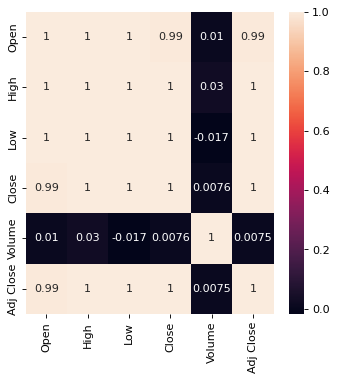

In [261]:
# mapa de calor correlación
corr = train_tweets[num_cols].corr()
plt.figure(figsize=(5,5), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)
plt.show()

Pues confirmamos que todas las variables son correlacionadas con **Adj Close**, así que nos quedamos con **Adj Close**.

In [262]:
train_tweets = train_tweets[['Date', 'Adj Close', 'Volume', 'sentiment', 'Target']]
train_tweets

,Date,Adj Close,Volume,sentiment,Target
0,2015-01-05,9993.290039,299610800.0,negativo,1
1,2015-01-06,9871.089844,282855400.0,negativo,0
2,2015-01-07,9891.390625,290122400.0,neutral,0
3,2015-01-08,10114.990234,320452300.0,neutral,0
4,2015-01-09,9718.990234,789490200.0,neutral,1
...,...,...,...,...,...
1018,2019-05-24,9174.599609,121673100.0,negativo,0
1019,2019-05-27,9216.400391,60178000.0,negativo,0
1020,2019-05-28,9191.799805,218900800.0,negativo,0
1021,2019-05-29,9080.500000,148987100.0,negativo,0


In [263]:
test_tweets = test_tweets[['test_index','Date', 'Adj Close', 'Volume', 'sentiment']]

Pues con estos datos ya podemos hacer nuestro modelo predictivo, primero vamos a prepocesar los datos para que nuestro modelo pueda entrenar con la menor cantidad de ruido posible.

## Preprocesamiento

In [264]:
# convertir sentiment a dummies
train_tweets = pd.get_dummies(train_tweets, columns=['sentiment'])
train_tweets

,Date,Adj Close,Volume,Target,sentiment_negativo,sentiment_neutral,sentiment_positivo
0,2015-01-05,9993.290039,299610800.0,1,1,0,0
1,2015-01-06,9871.089844,282855400.0,0,1,0,0
2,2015-01-07,9891.390625,290122400.0,0,0,1,0
3,2015-01-08,10114.990234,320452300.0,0,0,1,0
4,2015-01-09,9718.990234,789490200.0,1,0,1,0
...,...,...,...,...,...,...,...
1018,2019-05-24,9174.599609,121673100.0,0,1,0,0
1019,2019-05-27,9216.400391,60178000.0,0,1,0,0
1020,2019-05-28,9191.799805,218900800.0,0,1,0,0
1021,2019-05-29,9080.500000,148987100.0,0,1,0,0


In [265]:
test_tweets = pd.get_dummies(test_tweets, columns=['sentiment'])
test_tweets

,test_index,Date,Adj Close,Volume,sentiment_negativo,sentiment_neutral,sentiment_positivo
0,6557,2019-06-05,9150.500000,158753000.0,1,0,0
1,6558,2019-06-06,9169.200195,212720900.0,1,0,0
2,6559,2019-06-07,9236.099609,150664700.0,1,0,0
3,6560,2019-06-10,9294.099609,102323700.0,1,0,0
4,6561,2019-06-11,9282.099609,144701200.0,1,0,0
...,...,...,...,...,...,...,...
697,7276,2022-03-23,8328.400391,184043600.0,0,1,0
698,7278,2022-03-25,8330.599609,156189000.0,0,1,0
699,7279,2022-03-28,8365.599609,167961800.0,0,1,0
700,7281,2022-03-30,8550.599609,185389000.0,1,0,0


In [266]:
# estandarización de las variables númericas
num_cols = ['Volume', 'Adj Close']
# aplicar standarScaler a las variables númericas
scaler = StandardScaler()
train_tweets[num_cols] = scaler.fit_transform(train_tweets[num_cols])

train_tweets

,Date,Adj Close,Volume,Target,sentiment_negativo,sentiment_neutral,sentiment_positivo
0,2015-01-05,0.316969,0.722081,1,1,0,0
1,2015-01-06,0.173228,0.545958,0,1,0,0
2,2015-01-07,0.197108,0.622344,0,0,1,0
3,2015-01-08,0.460121,0.941154,0,0,1,0
4,2015-01-09,-0.005682,5.871398,1,0,1,0
...,...,...,...,...,...,...,...
1018,2019-05-24,-0.646033,-1.148293,0,1,0,0
1019,2019-05-27,-0.596864,-1.794693,0,1,0,0
1020,2019-05-28,-0.625801,-0.126294,0,1,0,0
1021,2019-05-29,-0.756719,-0.861185,0,1,0,0


In [267]:
test_tweets[num_cols] = scaler.transform(test_tweets[num_cols])
prep_test = test_tweets.copy()
prep_test = prep_test.drop(['test_index'], axis=1)
prep_test = prep_test.set_index('Date')

In [268]:
X = train_tweets.drop(['Target'], axis=1).set_index('Date')
y = train_tweets['Target']

## Modelización

Para la modelización de nuestro problema nos valdremos de los modelos supervisados de regresión y clasificación, los más populares son Random Forest y Gradient Boosting.

### [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [269]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_criterion,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
5,entropy,3,150,0.574043,0.018286,0.637475,0.006814
1,gini,3,150,0.573059,0.017311,0.640165,0.005038
3,gini,20,150,0.557741,0.036667,1.000000,0.000000
2,gini,10,150,0.555469,0.034710,0.958823,0.004583
6,entropy,10,150,0.555144,0.038642,0.938112,0.007488


In [270]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 150} : 0.5740427227801689 accuracy


In [271]:
random_forest = grid.best_estimator_

### [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [272]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators'  : [50, 100, 500, 1000],
              'max_features'  : ['auto', 'sqrt', 'log2'],
              'max_depth'     : [None, 1, 3, 5, 10, 20],
              'subsample'     : [0.5, 1],
              'learning_rate' : [0.001, 0.01, 0.1]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingClassifier(random_state=123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head()

,param_learning_rate,param_max_depth,param_max_features,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
393,0.1,10,sqrt,50,1,0.579265,0.006343,1.00000,0.000000
401,0.1,10,log2,50,1,0.579265,0.006343,1.00000,0.000000
381,0.1,5,log2,500,1,0.579257,0.003593,1.00000,0.000000
373,0.1,5,sqrt,500,1,0.579257,0.003593,1.00000,0.000000
215,0.01,3,log2,1000,1,0.578262,0.012610,0.79599,0.008613


In [273]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50, 'subsample': 1} : 0.5792651371398999 accuracy


In [274]:
gradient_boosting = grid.best_estimator_

Vemos que los modelos resultan tener un *accuracy* estimado muy parecido alrededor del 57%, por lo que no resulta ser muy confiable, veamos en cuanto le aporta los tweets a nuestro modelo con mayor *accuracy*

In [275]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X.columns,
                             'importancia': gradient_boosting.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,Volume,0.486193
0,Adj Close,0.482502
2,sentiment_negativo,0.013338
3,sentiment_neutral,0.009969
4,sentiment_positivo,0.007998


In [276]:
importancia = permutation_importance(
                estimator    = gradient_boosting,
                X            = X,
                y            = y,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,0.597824,0.010838,Adj Close
1,0.552540,0.007345,Volume
2,0.306100,0.008279,sentiment_negativo
4,0.203825,0.010341,sentiment_positivo
3,0.132291,0.007384,sentiment_neutral


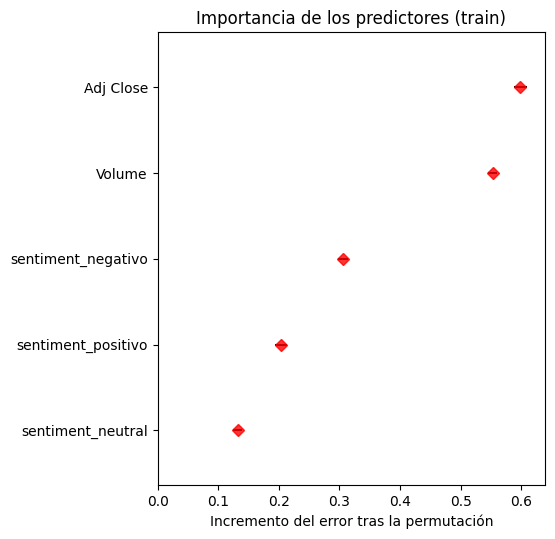

In [277]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6), dpi=100, facecolor='w', edgecolor='k')
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación')
plt.show()

Al final parece ser que nuestra variable sentimiento no aporta mucho valor a nuestro modelo, pero es interesante ver que de los 3 sentimientos, el que más aporta es el sentimiento negativo, habría que recabar más datos, midiendo el volumen de los tweets, a ver si realmente pueden llegar a cambiar la tendencia del indicador.

## Conclusiones

* Los tweets no aportan mucho valor a nuestro modelo, pero es interesante ver que de los 3 sentimientos, el que más aporta es el sentimiento negativo, habría que recabar más datos, midiendo el volumen de los tweets, a ver si realmente pueden llegar a cambiar la tendencia del indicador.

*  El modelo Random Forest es muy similar al modelo Gradient Boosting, en este caso el Gradient Boosting es más confiable pero a costo de eficiencia de eficiencia computacional, mientras que el Random Forest es más eficiente computacionalmente, cabe destacar que los modelos aplicados tendrían el problema de descartar las fechas como variable utilizable. Para solucionar este problema se puede hacer una Serie Temporal, pero esto tendría que dejar a los tweets como variable utilizable ya que no se puede predecir el sentimiento de un tweet en una fecha dada.

## Predicciones

In [278]:
predicciones = gradient_boosting.predict(prep_test)
index = test_tweets['test_index']
# dataframe con los resultados
resultados = pd.DataFrame({'test_index': index, 'Target': predicciones})

resultados.to_csv('predictions.csv', index=False)
resultados.to_json('predictions.json')